In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
# from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# uncomment to disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


# Case 1

10.0

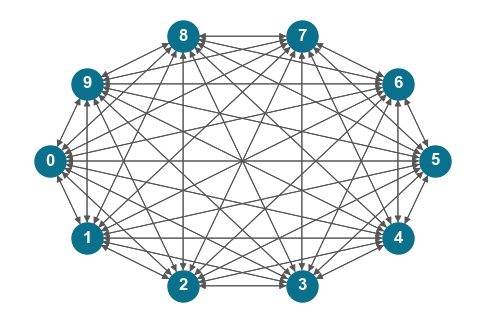

In [69]:
graph_1, edge_list_1, node_list_1 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)

# nx.draw(graph, with_labels=True, pos=nx.shell_layout(graph) , font_weight='bold', ax=ax, **options)
maxentep.draw_graph(graph_1, dpi =100)
dof_1 = maxentep.graph_dof(graph_1.edges(), node_list_1)
dof_1

Reference Model

In [5]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
# mobility_matrix[1,:]= 0
# mobility_matrix[:,1]= 0
mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(mobility_matrix, mobility_matrix_diag)
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(mobility_matrix))
# np.diagonal(mobility_matrix)
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


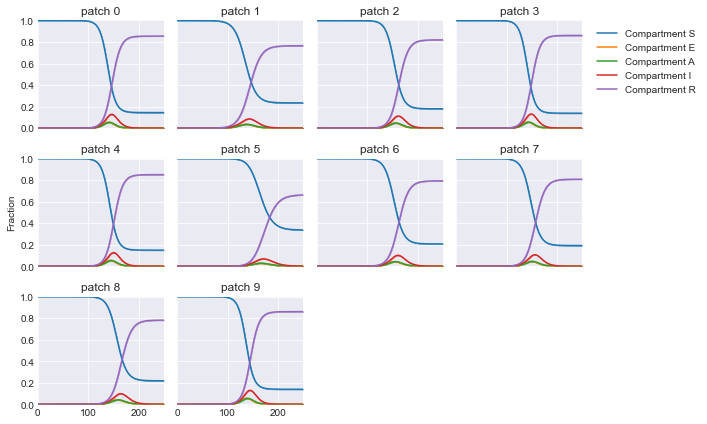

In [6]:
def gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, mobility_matrix=mobility_matrix, population=None, area= None):
    tmat = maxentep.TransitionMatrix(compartments, [1,2])
#     eta = 1/2
#     alpha = 1/2
#     mu = 1/5
    tmat.add_transition('E', 'A', 1/eta, 0)
    tmat.add_transition('A', 'I', 1/alpha, 0)
    tmat.add_transition('I', 'R', 1/mu, 0)
    infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
#     timesteps = 250
    model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

    # starting fractions probabilities
    start = np.zeros((M,C)) #anywhere
    # Assume starting from Node 1
    initial_exposed = 1/population[1]
    start[1,0] = initial_exposed
    # start[0,0] = 0.05
#     beta = 0.03
    mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
    ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
    ref_traj = ref_traj[tf.newaxis, ...]
    return ref_traj
ref_traj_1 = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, population=population,
                          area=area, mobility_matrix=mobility_matrix)
maxentep.patch_quantile(ref_traj_1, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Add Restraints

Restraints are set in this time range: [0, 180]
122 0.015657691 0.0334527774824479
73 3.4974753e-05 0.0
45 8.8457443e-07 0.007945232507143487
108 0.0028866034 0.01442355736609968
3 1.1672253e-11 0.0
115 0.0103614405 0.048952081556095116
66 2.0206047e-05 0.01900862218585365
24 4.1891177e-08 0.0017510667188805676
17 1.0552815e-08 0.0
38 2.9669027e-07 0.01716505239736926
171 0.030818883 0.03270556912915374
45 7.988033e-07 0.0
101 0.0019340848 0.0011484284439040055
129 0.06601216 0.04265028903508236
66 1.909915e-05 0.010484632361084694
17 8.088455e-09 0.0
122 0.0048208325 0.058085383813693145
157 0.10557671 0.11378249826150724
31 6.046642e-08 0.009713098335787616
17 6.7200525e-09 0.02623053766147473
59 3.5139087e-06 0.0
3 6.451803e-12 0.0
171 0.58774334 0.5720416112944946
136 0.03894579 0.006839909049684845
3 1.8099601e-10 0.0
129 0.0497725 0.0580935019170498
52 3.4130644e-06 0.0
38 5.0210974e-07 0.015624464143942097
108 0.0067300834 0.026914973994460332
143 0.32328814 0.3375559340915126
8

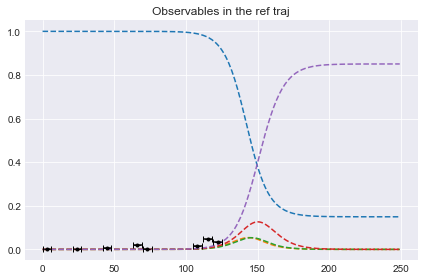

In [7]:
npoints = 4
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
def gen_restraints(ref_traj):
    prior = maxentep.EmptyPrior()

    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    # Visualizing restraints
    restrained_patch = restrained_patches[0]
    restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.02, start_time=0, end_time=180)
    plt.plot(ref_traj[0,:,restrained_patch,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[0]):
        pf(plt.gca(), 0)
    plt.title('Observables in the ref traj')
    plt.tight_layout()
    return restraints, plot_fxns_list, restrained_patches
restraints_1, plot_fxns_list_1, restrained_patches_1 = gen_restraints(ref_traj_1)

# Sample

In [8]:
def gen_samples(mobility_matrix, timesteps =250, area = area, populations = population, sparse=False):
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 1, 1)
    tmat.add_transition('A', 'I', 3, 1)
    tmat.add_transition('I', 'R', 7, 2)
    hyper_pram = maxentep.ParameterHypers()
    hyper_pram.beta_low = 0.005
    hyper_pram.beta_high = 0.05
    hyper_pram.beta_var = 0.03
    hyper_pram.start_high = 2e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 4e-6
    start_logits = np.zeros((M))
    param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',hypers = hyper_pram)
    import tqdm
    N = 512
    batches = 16
    total_batches = N * batches
    outs = []
    infect = maxentep.contact_infection_func(infections_compartments, area = area)
    model = maxentep.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        if sparse:
            # This updates the sampled R_dist based on the sparse mobility network (make sure sparse=True when calling)
            R_dist = ps[0]
            sparse_R_dist_list = []
            for i in range(R_dist.shape[0]):
                sparse_R_dist = R_dist[i].numpy().flatten()
                sparse_R_dist[np.where(mobility_matrix.flatten()==0)] = 0
                sparse_R_dist_list.append(sparse_R_dist.reshape(M,M))
            #     print(sparse_R_dist)
            ps[0] = tf.stack(sparse_R_dist_list)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    param_batch = prior_prams[0]
    mask = tf.greater(param_batch[2], 0)
    start_exposed_dist = tf.boolean_mask(param_batch[2], mask).numpy()
    # prior_param_dist = maxentep.get_dist(prior_prams)
    # maxentep.plot_dist(*prior_param_dist)
    return trajs
trajs_1 = gen_samples(mobility_matrix, timesteps =250, area = area, populations = population)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.48s/it]


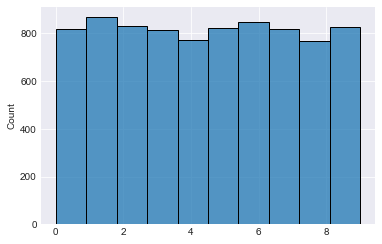

In [9]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
# print(np.where(prior_exposed_patch==0))
sns.histplot(x=prior_exposed_patch_1, label='Prior',
            color='C0',bins=M)

In [10]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments] and compares to a ref_traj
    '''
#     weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.06)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()

Plotting 10 patches in a 3 x 4 grid


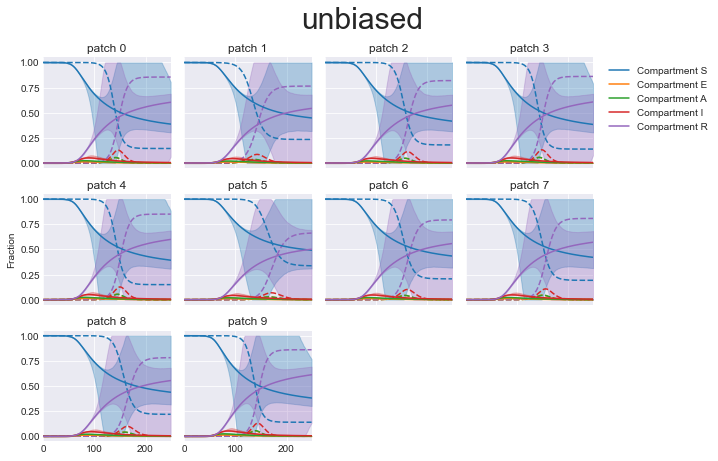

In [11]:
compare_to_ref(ref_traj_1,trajs_1, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

# Applying MaxEnt

Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0106 - weight-entropy: 6.9188
Epoch 2/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0060 - weight-entropy: 6.8590
Epoch 3/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0051 - weight-entropy: 6.8002
Epoch 4/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0050 - weight-entropy: 6.7701
Epoch 5/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0050 - weight-entropy: 6.7627
Epoch 6/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0049 - weight-entropy: 6.7672
Epoch 7/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0047 - weight-entropy: 6.7755
Epoch 8/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0046 - weight-entropy: 6.7825
Epoch 9/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0045 - weight-entropy: 6.7856
Epoch 10/500
8/8 [==============================] - 0s 2ms/step - loss: 0

8/8 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 6.1269
Epoch 80/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.1173
Epoch 81/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.1101
Epoch 82/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.1000
Epoch 83/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.0926
Epoch 84/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 6.0830
Epoch 85/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 6.0744
Epoch 86/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 6.0628
Epoch 87/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 6.0567
Epoch 88/500
8/8 [==============================] - 0s 1ms/step - loss: 0.001

8/8 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 5.6113
Epoch 157/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 5.6041
Epoch 158/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 5.6171
Epoch 159/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 5.6107
Epoch 160/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 5.6039
Epoch 161/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 5.5864
Epoch 162/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 5.5942
Epoch 163/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 5.5724
Epoch 164/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 5.5723
Epoch 165/500
8/8 [==============================] - 0s 2ms/step - lo

8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 5.3681
Epoch 234/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 5.3662
Epoch 235/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.3753
Epoch 236/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.3580
Epoch 237/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 5.3870
Epoch 238/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.3584
Epoch 239/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.3671
Epoch 240/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 5.3551
Epoch 241/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 5.3568
Epoch 242/500
8/8 [==============================] - 0s 2ms/step - lo

8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 5.2052
Epoch 311/500
8/8 [==============================] - 0s 1ms/step - loss: 8.9169e-04 - weight-entropy: 5.1839
Epoch 312/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 5.1843
Epoch 313/500
8/8 [==============================] - 0s 2ms/step - loss: 9.5041e-04 - weight-entropy: 5.2015
Epoch 314/500
8/8 [==============================] - 0s 1ms/step - loss: 8.6228e-04 - weight-entropy: 5.1615
Epoch 315/500
8/8 [==============================] - 0s 1ms/step - loss: 8.8349e-04 - weight-entropy: 5.1704
Epoch 316/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 5.2135
Epoch 317/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 5.1841
Epoch 318/500
8/8 [==============================] - 0s 1ms/step - loss: 8.4363e-04 - weight-entropy: 5.1411
Epoch 319/500
8/8 [==============================

8/8 [==============================] - 0s 2ms/step - loss: 7.9371e-04 - weight-entropy: 5.0211
Epoch 386/500
8/8 [==============================] - 0s 2ms/step - loss: 7.6577e-04 - weight-entropy: 4.9940
Epoch 387/500
8/8 [==============================] - 0s 2ms/step - loss: 8.2223e-04 - weight-entropy: 4.9972
Epoch 388/500
8/8 [==============================] - 0s 1ms/step - loss: 8.0616e-04 - weight-entropy: 5.0210
Epoch 389/500
8/8 [==============================] - 0s 2ms/step - loss: 8.5256e-04 - weight-entropy: 5.0692
Epoch 390/500
8/8 [==============================] - 0s 1ms/step - loss: 8.2973e-04 - weight-entropy: 4.9751
Epoch 391/500
8/8 [==============================] - 0s 2ms/step - loss: 7.8791e-04 - weight-entropy: 4.9822
Epoch 392/500
8/8 [==============================] - 0s 1ms/step - loss: 8.3343e-04 - weight-entropy: 5.0135
Epoch 393/500
8/8 [==============================] - 0s 1ms/step - loss: 8.8495e-04 - weight-entropy: 5.0372
Epoch 394/500
8/8 [==============

8/8 [==============================] - 0s 1ms/step - loss: 6.7539e-04 - weight-entropy: 4.8861
Epoch 461/500
8/8 [==============================] - 0s 2ms/step - loss: 7.8027e-04 - weight-entropy: 4.9098
Epoch 462/500
8/8 [==============================] - 0s 2ms/step - loss: 7.1463e-04 - weight-entropy: 4.9061
Epoch 463/500
8/8 [==============================] - 0s 3ms/step - loss: 7.8433e-04 - weight-entropy: 4.9137
Epoch 464/500
8/8 [==============================] - 0s 2ms/step - loss: 8.1484e-04 - weight-entropy: 4.9039
Epoch 465/500
8/8 [==============================] - 0s 2ms/step - loss: 8.5586e-04 - weight-entropy: 4.9364
Epoch 466/500
8/8 [==============================] - 0s 2ms/step - loss: 7.7156e-04 - weight-entropy: 4.9360
Epoch 467/500
8/8 [==============================] - 0s 1ms/step - loss: 7.7420e-04 - weight-entropy: 4.8875
Epoch 468/500
8/8 [==============================] - 0s 1ms/step - loss: 6.7977e-04 - weight-entropy: 4.8723
Epoch 469/500
8/8 [==============

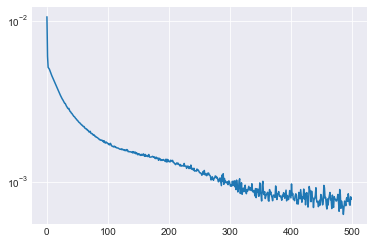

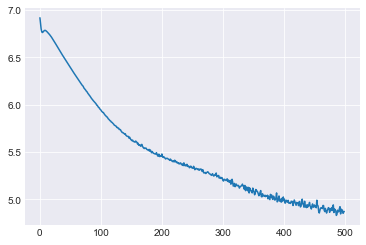

In [12]:
def maxent_fit(trajs,restraints):
    me_model = maxentep.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=1024,epochs=500)
    plt.plot(me_history.history['loss'])
    plt.yscale('log')
    plt.show()
    plt.plot(me_history.history['weight-entropy'])
    return me_model
me_model_1 = maxent_fit(trajs_1, restraints_1)

In [13]:
def compare_patches(ref_traj, trajs,weights_dict, method, restrained_patches,plot_fxns_list,
                    *args, figsize=(10, 6), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()


Plotting 10 patches in a 3 x 4 grid


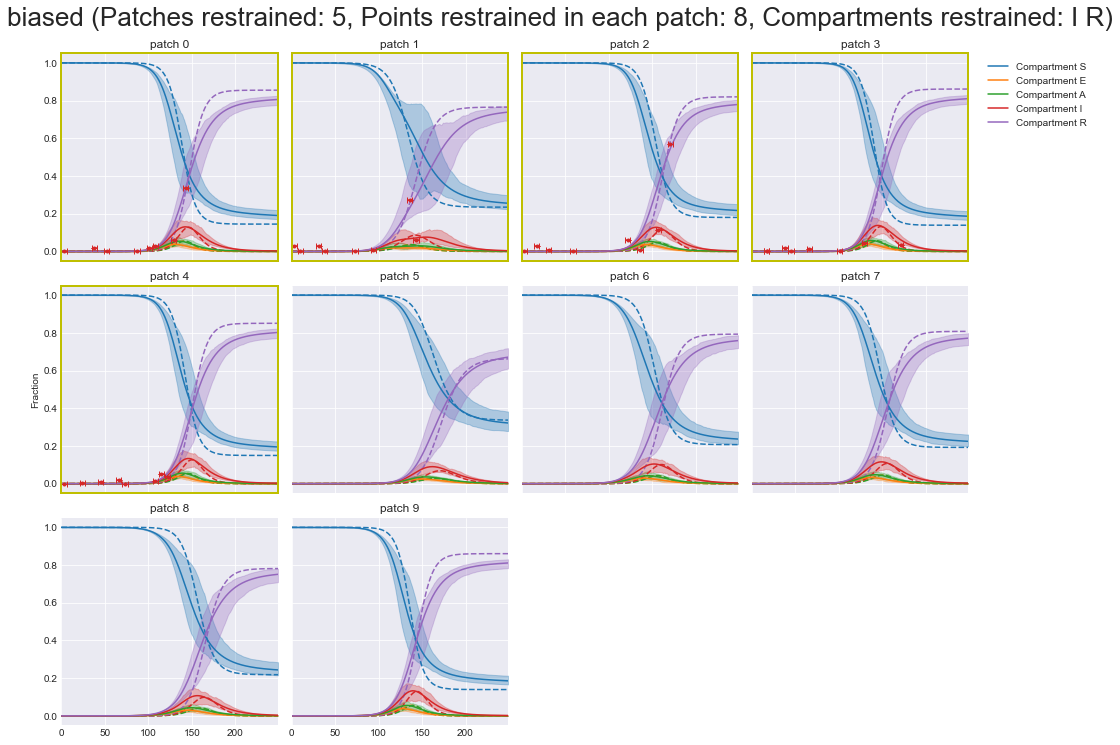

In [14]:
weights_dict_1 = {'unbiased':None, 'biased':me_model_1.traj_weights}
compare_patches(ref_traj_1, trajs_1, weights_dict_1,'biased', restrained_patches_1,plot_fxns_list_1,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

In [15]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
me_w_1 = me_model_1.traj_weights
maxentep.p0_map(prior_exposed_patch_1, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_1, M, weights = me_w_1, title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

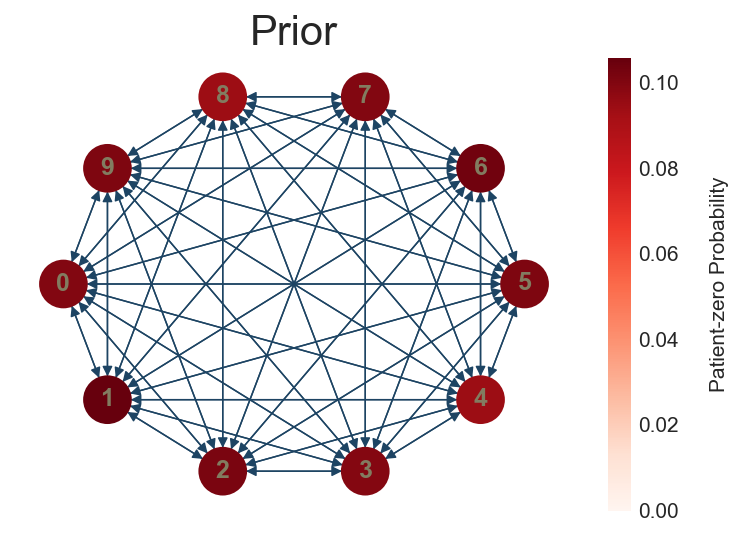

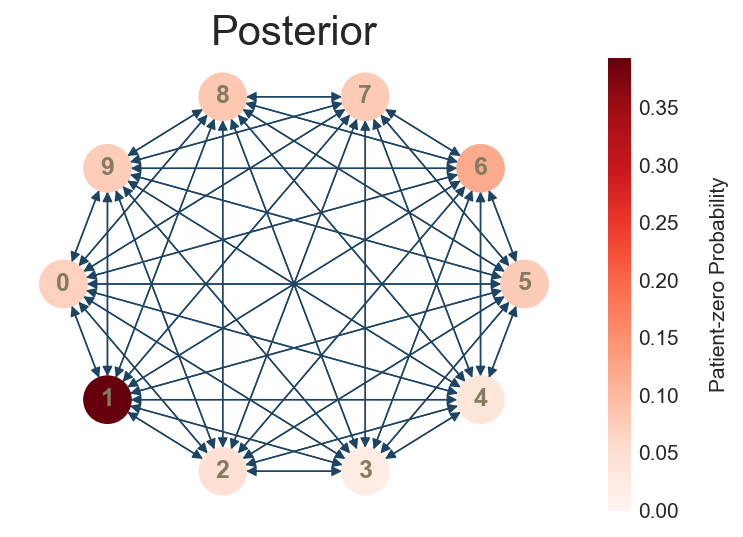

In [16]:
exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M)
weighted_exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M, weights=me_w_1)
maxentep.draw_graph(graph_1, weights=exposed_prob_1, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_1, weights=weighted_exposed_prob_1, title='Posterior', heatmap=True)

In [17]:
# posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_1, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.39353714831953457, 'patch 1'), (0.11844845686456314, 'patch 6'), (0.0823877532380657, 'patch 8'), (0.07883410291135923, 'patch 7'), (0.07669772400003945, 'patch 5')]


 # Case 2

6.9

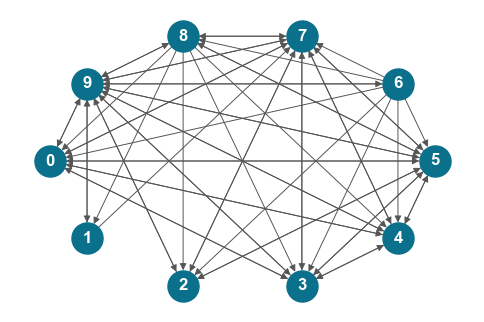

In [70]:
graph_2, edge_list_2, node_list_2 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)
graph_2.remove_edges_from([(1, i) for i in range(0,7) if i!=1])
graph_2.remove_edges_from([(i, 1) for i in range(0,8)  if i!=1])
graph_2.remove_edges_from([(2, i) for i in range(0,5) if i!=2])
graph_2.remove_edges_from([(i,2) for i in range(0,5)  if i!=2])
graph_2.remove_edges_from([(i,8) for i in range(0,5)  if i!=8])
graph_2.remove_edges_from([(i,6) for i in range(0,9)  if i!=6])
maxentep.draw_graph(graph_2, dpi=100)
# nx.draw(graph_2, with_labels=True, pos=nx.shell_layout(graph_2) , font_weight='bold', ax=ax, **options)
dof_2 = maxentep.graph_dof(graph_2.edges(), node_list_2)
dof_2

In [19]:
def sparse_graph_mobility(sparse_graph, fully_connected_mobility_matrix):
    R'''
    Generates a sprase mobility matrix based on a sparse graph and a fully connected mobility matrix inputs
    '''
    sparse_mobility_matrix = np.zeros_like(fully_connected_mobility_matrix)
    for i, edge in enumerate(sparse_graph.edges()):
        sparse_mobility_matrix[edge[0], edge[1]] = fully_connected_mobility_matrix[edge[0], edge[1]]
    return sparse_mobility_matrix


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


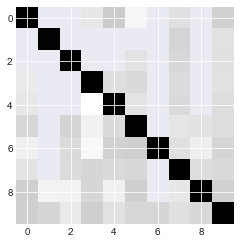

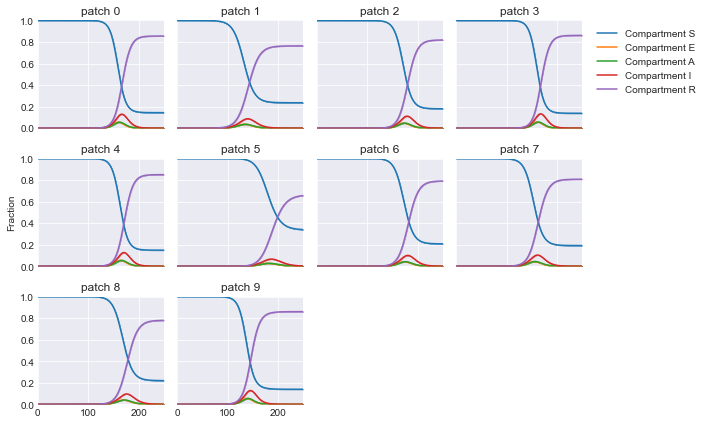

In [20]:
sparse_mobility_matrix_2 = sparse_graph_mobility(graph_2, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_2))
sparse_ref_traj_2 = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250,
                               population=population, area=area, mobility_matrix=sparse_mobility_matrix_2)
maxentep.patch_quantile(sparse_ref_traj_2, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

In [76]:
restraints_2, plot_fxns_list_2, restrained_patches_2 = gen_restraints(sparse_ref_traj_2)

Restraints are set in this time range: [0, 180]
24 6.795088e-06 0.0
136 0.084751785 0.08181368361085296
52 9.56619e-05 0.008717927447226688
164 0.031145249 0.04552985512880797
129 0.20048866 0.1994543558736492
108 0.03639557 0.05118238469476537
171 0.71831286 0.7198577633047335
66 0.0007226405 0.0
157 0.044070575 0.07192094437497124
17 2.6327733e-09 0.020751715973786014
66 1.7823071e-06 0.0003776181425799558
24 8.122406e-09 0.0
10 2.809025e-10 0.0
59 1.1666452e-06 0.0017202061139214458
157 0.09182517 0.10686410405865103
164 0.16816087 0.17942066504299484
94 1.6444712e-05 0.0
101 4.118972e-05 0.0
157 0.034474272 0.0021870433134894007
108 0.00010226164 0.0
87 8.952168e-06 0.019678840965320507
108 0.0001464436 0.04618578977896688
164 0.12521389 0.13606091850119034
52 5.8487505e-08 0.0
122 0.0011445872 0.01259734814949298
136 0.0070084697 0.00981698785071544
45 2.0701155e-08 0.0
52 6.214541e-08 0.0
24 3.8504164e-10 0.0
122 0.001600617 0.012420781359982437
66 6.249834e-07 0.0
59 2.1535779e-

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.68s/it]


Plotting 10 patches in a 3 x 4 grid


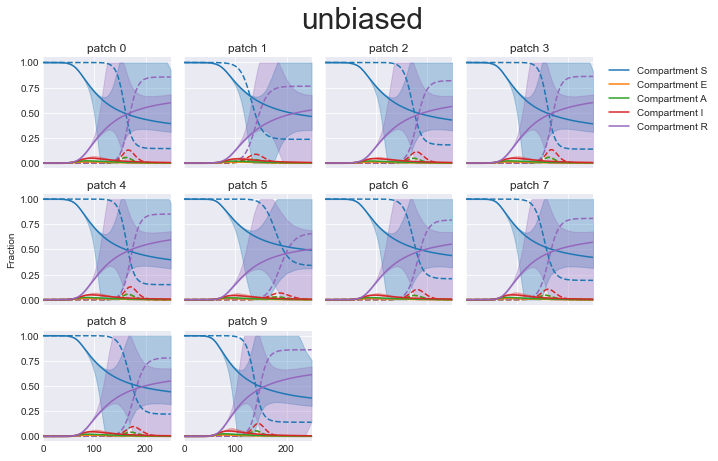

In [22]:
sparse_trajs_2 = gen_samples(sparse_mobility_matrix_2, timesteps =250, area = area, populations = population, sparse=True)
compare_to_ref(sparse_ref_traj_2, sparse_trajs_2, weights=None, method='unbiased',
               patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0161 - weight-entropy: 6.9169
Epoch 2/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0106 - weight-entropy: 6.8462
Epoch 3/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0096 - weight-entropy: 6.7748
Epoch 4/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0097 - weight-entropy: 6.7364
Epoch 5/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0097 - weight-entropy: 6.7254
Epoch 6/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0097 - weight-entropy: 6.7311
Epoch 7/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0096 - weight-entropy: 6.7426
Epoch 8/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0096 - weight-entropy: 6.7549
Epoch 9/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0096 - weight-entropy: 6.7642
Epoch 10/500
8/8 [==============================] - 0s 2ms/step - loss: 0

8/8 [==============================] - 0s 2ms/step - loss: 0.0055 - weight-entropy: 5.9722
Epoch 79/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0052 - weight-entropy: 5.9089
Epoch 80/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0052 - weight-entropy: 5.8632
Epoch 81/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0050 - weight-entropy: 5.8113
Epoch 82/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0050 - weight-entropy: 5.7950
Epoch 83/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0048 - weight-entropy: 5.7664
Epoch 84/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0048 - weight-entropy: 5.7412
Epoch 85/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0050 - weight-entropy: 5.7416
Epoch 86/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0045 - weight-entropy: 5.6689
Epoch 87/500
8/8 [==============================] - 0s 1ms/step - loss: 0.004

8/8 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.0969
Epoch 157/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.1142
Epoch 158/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.1369
Epoch 159/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0622
Epoch 160/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0055
Epoch 161/500
8/8 [==============================] - 0s 2ms/step - loss: 9.7310e-04 - weight-entropy: 3.9755
Epoch 162/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.1219
Epoch 163/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0510
Epoch 164/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 4.2097
Epoch 165/500
8/8 [==============================] - 0s 1ms/step 

8/8 [==============================] - 0s 1ms/step - loss: 6.5790e-04 - weight-entropy: 3.4084
Epoch 233/500
8/8 [==============================] - 0s 2ms/step - loss: 7.2497e-04 - weight-entropy: 3.3633
Epoch 234/500
8/8 [==============================] - 0s 2ms/step - loss: 7.4764e-04 - weight-entropy: 3.4174
Epoch 235/500
8/8 [==============================] - 0s 2ms/step - loss: 6.0788e-04 - weight-entropy: 3.3988
Epoch 236/500
8/8 [==============================] - 0s 1ms/step - loss: 7.7285e-04 - weight-entropy: 3.4787
Epoch 237/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4733
Epoch 238/500
8/8 [==============================] - 0s 1ms/step - loss: 7.0432e-04 - weight-entropy: 3.3649
Epoch 239/500
8/8 [==============================] - 0s 1ms/step - loss: 6.5938e-04 - weight-entropy: 3.3970
Epoch 240/500
8/8 [==============================] - 0s 2ms/step - loss: 6.9568e-04 - weight-entropy: 3.2961
Epoch 241/500
8/8 [==================

8/8 [==============================] - 0s 1ms/step - loss: 6.2361e-04 - weight-entropy: 3.1785
Epoch 307/500
8/8 [==============================] - ETA: 0s - loss: 7.5398e-04 - weight-entropy: 3.36 - 0s 1ms/step - loss: 6.2198e-04 - weight-entropy: 3.1315
Epoch 308/500
8/8 [==============================] - 0s 1ms/step - loss: 6.3292e-04 - weight-entropy: 3.2303
Epoch 309/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 3.4751
Epoch 310/500
8/8 [==============================] - 0s 1ms/step - loss: 5.3878e-04 - weight-entropy: 3.1453
Epoch 311/500
8/8 [==============================] - 0s 1ms/step - loss: 6.0482e-04 - weight-entropy: 3.1546
Epoch 312/500
8/8 [==============================] - 0s 1ms/step - loss: 6.1108e-04 - weight-entropy: 3.0526
Epoch 313/500
8/8 [==============================] - 0s 1ms/step - loss: 6.9573e-04 - weight-entropy: 3.2065
Epoch 314/500
8/8 [==============================] - 0s 1ms/step - loss: 8.9318e-04 - weight-e

8/8 [==============================] - 0s 1ms/step - loss: 8.5375e-04 - weight-entropy: 3.1540
Epoch 381/500
8/8 [==============================] - 0s 1ms/step - loss: 6.0722e-04 - weight-entropy: 3.0098
Epoch 382/500
8/8 [==============================] - 0s 2ms/step - loss: 5.2510e-04 - weight-entropy: 3.0181
Epoch 383/500
8/8 [==============================] - 0s 1ms/step - loss: 8.0019e-04 - weight-entropy: 3.0279
Epoch 384/500
8/8 [==============================] - 0s 1ms/step - loss: 7.2797e-04 - weight-entropy: 3.0128
Epoch 385/500
8/8 [==============================] - 0s 2ms/step - loss: 5.6151e-04 - weight-entropy: 3.0464
Epoch 386/500
8/8 [==============================] - 0s 2ms/step - loss: 7.3904e-04 - weight-entropy: 3.0011
Epoch 387/500
8/8 [==============================] - 0s 1ms/step - loss: 5.5903e-04 - weight-entropy: 2.9572
Epoch 388/500
8/8 [==============================] - 0s 1ms/step - loss: 5.9076e-04 - weight-entropy: 3.0555
Epoch 389/500
8/8 [==============

8/8 [==============================] - 0s 1ms/step - loss: 4.8276e-04 - weight-entropy: 2.9239
Epoch 456/500
8/8 [==============================] - 0s 1ms/step - loss: 6.6758e-04 - weight-entropy: 2.9859
Epoch 457/500
8/8 [==============================] - 0s 1ms/step - loss: 6.2039e-04 - weight-entropy: 2.9719
Epoch 458/500
8/8 [==============================] - 0s 1ms/step - loss: 5.7557e-04 - weight-entropy: 3.0241
Epoch 459/500
8/8 [==============================] - 0s 1ms/step - loss: 5.3340e-04 - weight-entropy: 2.9572
Epoch 460/500
8/8 [==============================] - 0s 1ms/step - loss: 6.2134e-04 - weight-entropy: 2.9863
Epoch 461/500
8/8 [==============================] - 0s 3ms/step - loss: 6.4845e-04 - weight-entropy: 2.8551
Epoch 462/500
8/8 [==============================] - 0s 2ms/step - loss: 7.3817e-04 - weight-entropy: 3.1266
Epoch 463/500
8/8 [==============================] - 0s 2ms/step - loss: 6.6807e-04 - weight-entropy: 2.9933
Epoch 464/500
8/8 [==============

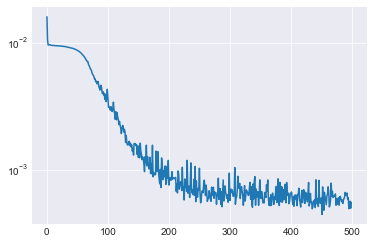

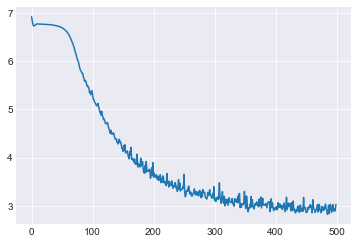

In [77]:
sparse_me_model_2 = maxent_fit(sparse_trajs_2, restraints_2)

Plotting 10 patches in a 3 x 4 grid


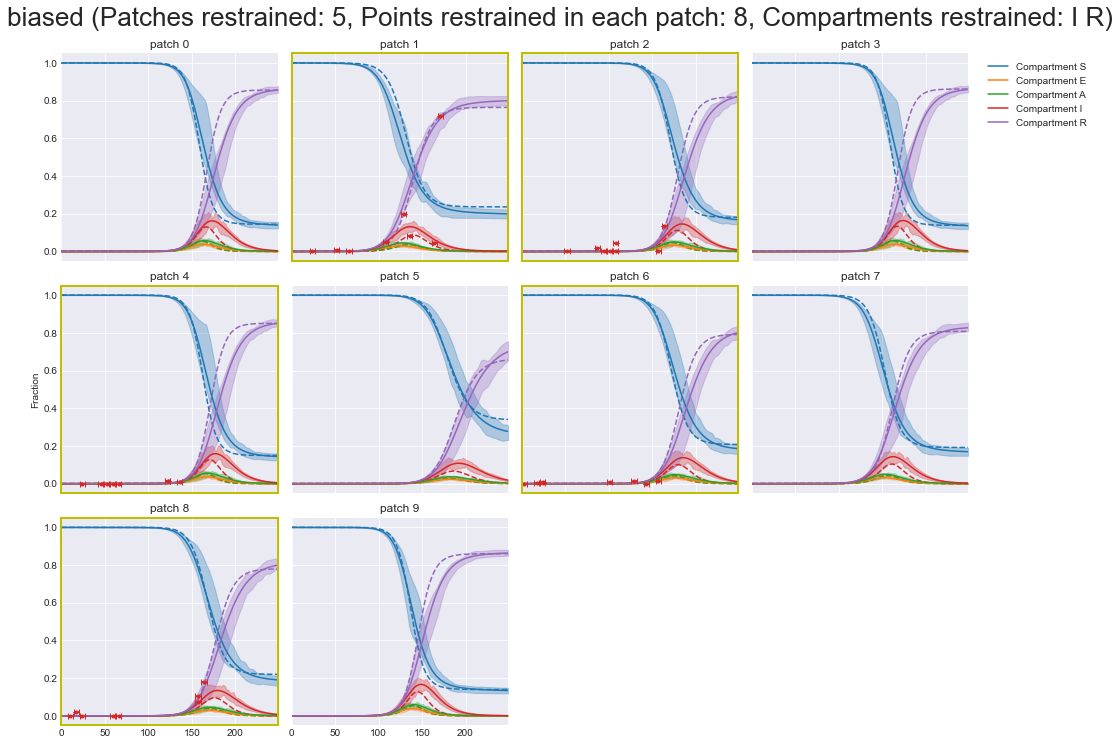

In [78]:
weights_dict_2 = {'unbiased':None, 'biased':sparse_me_model_2.traj_weights}
compare_patches(sparse_ref_traj_2, sparse_trajs_2, weights_dict_2,'biased', restrained_patches_2, plot_fxns_list_2,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

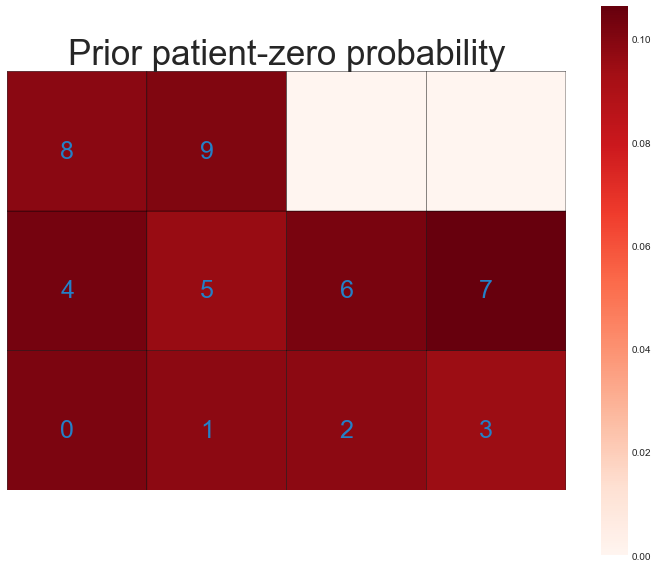

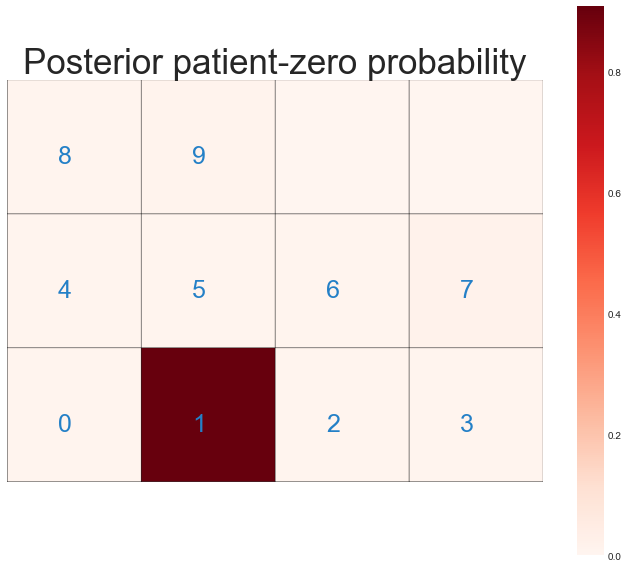

In [79]:
me_w_2 = sparse_me_model_2.traj_weights
prior_exposed_patch_2 = maxentep.exposed_finder(sparse_trajs_2)
maxentep.p0_map(prior_exposed_patch_2, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_2, M, weights = me_w_2, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

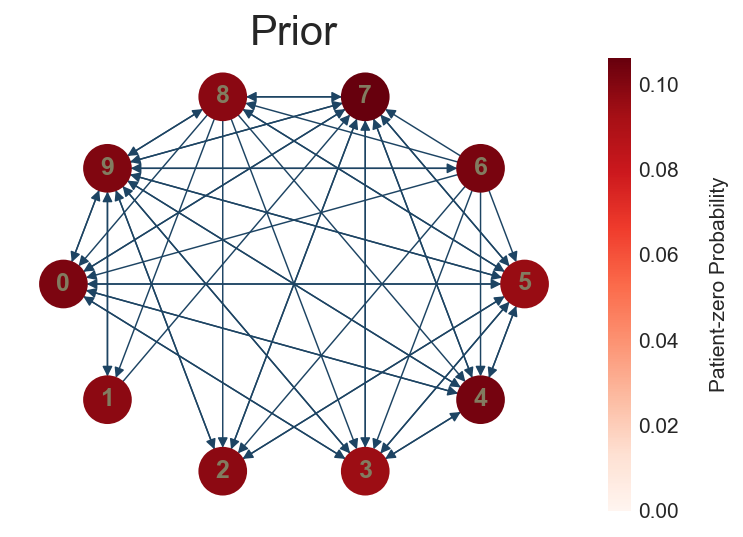

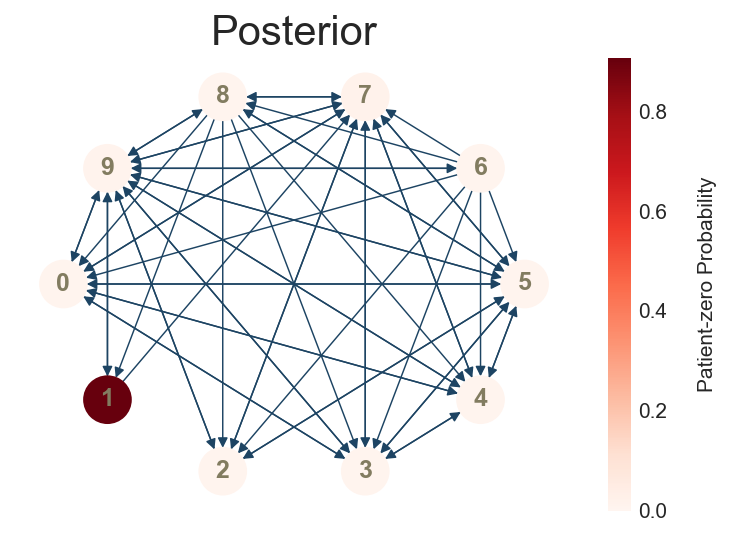

In [80]:
exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M)
weighted_exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M, weights=me_w_2)
maxentep.draw_graph(graph_2, weights=exposed_prob_2, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_2, weights=weighted_exposed_prob_2, title='Posterior', heatmap=True)

In [81]:
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_2, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.9078853200186836, 'patch 1'), (0.017968122674013414, 'patch 7'), (0.011906455896289343, 'patch 9'), (0.009597770071116984, 'patch 5'), (0.009457176313637397, 'patch 0')]


# Case 3

4.5

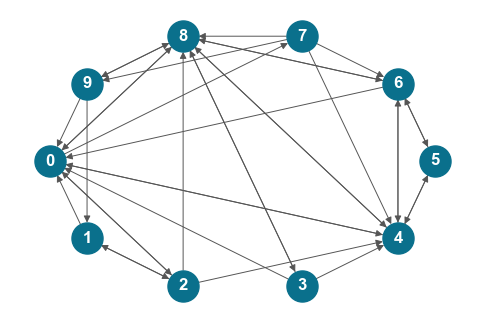

In [71]:
graph_3, edge_list_3, node_list_3 = maxentep.gen_graph(10)
graph_3.remove_edges_from([(1, i) for i in range(3,9)])
graph_3.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i != 1])
graph_3.remove_edges_from([(i, 2) for i in range(3,9) ])
graph_3.remove_edges_from([(i, 6) for i in range(0,4)])
graph_3.remove_edges_from([(i, 7) for i in range(1,10) if i != 7])
graph_3.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_3.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_3.remove_edges_from([(9,i) for i in range(2,8)])
graph_3.remove_edges_from([(i,9) for i in range(0,7)])
# graph.remove_edges_from([(i,4) for i in range(0,7)])
maxentep.draw_graph(graph_3,dpi=100)
dof_3 = maxentep.graph_dof(graph_3.edges(), node_list_3)
dof_3


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


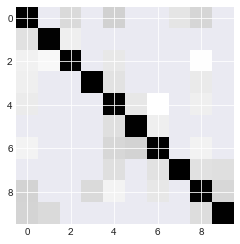

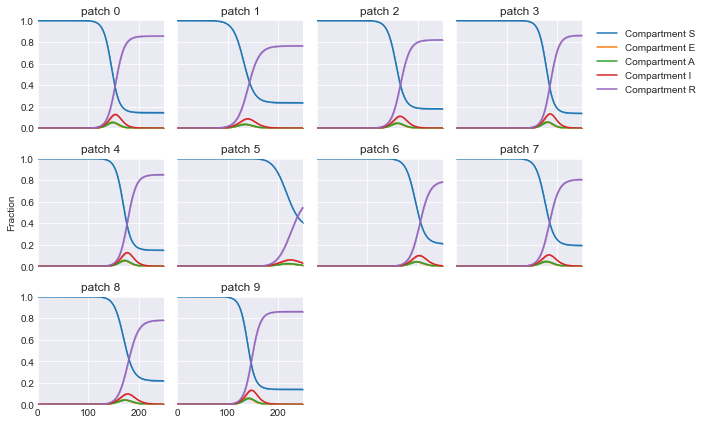

In [29]:
sparse_mobility_matrix_3 = sparse_graph_mobility(graph_3, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_3))
sparse_ref_traj_3 = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, population=population,
                               area=area, mobility_matrix=sparse_mobility_matrix_3)
maxentep.patch_quantile(sparse_ref_traj_3, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [0, 180]
115 0.0044337963 0.018242376763068058
122 0.010426169 0.026359611428629755
59 3.4394288e-06 0.0
157 0.12073916 0.14011681473949222
94 0.00046294 0.0
52 1.825178e-06 0.00866398424097343
24 2.4046718e-08 0.0
164 0.64650774 0.6609951101181513
59 0.00018661868 0.0
17 3.5142677e-06 0.010159218316328229
115 0.0302027 0.02430719912446446
31 1.3212618e-05 0.007417060141844507
115 0.068017974 0.07925634444078979
17 5.2555047e-06 0.0
136 0.31087545 0.30239404047518037
171 0.71897274 0.7621233655461319
136 0.00438724 0.024608061559084286
101 4.937529e-05 0.00130595507546433
24 4.4044615e-10 0.007340381754111133
73 1.1133333e-06 0.00968419830395032
45 2.0028555e-08 0.03785899805505269
59 1.8560856e-07 0.0
129 0.002724236 0.04424156126135612
143 0.015579346 0.056588690096345665
150 0.12491901 0.1034188875094201
157 0.09147187 0.073357392532455
87 0.0002657706 0.003503010967491365
31 1.3167735e-07 0.030988474155702255
143 0.3129042 0.3026764171125448
7

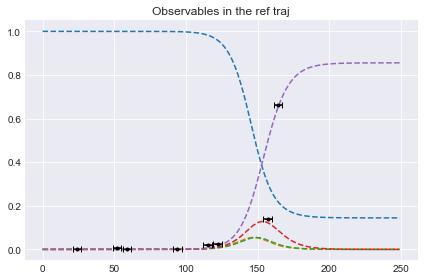

In [52]:
restraints_3, plot_fxns_list_3, restrained_patches_3 = gen_restraints(sparse_ref_traj_3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:28<00:00,  1.75s/it]


Plotting 10 patches in a 3 x 4 grid


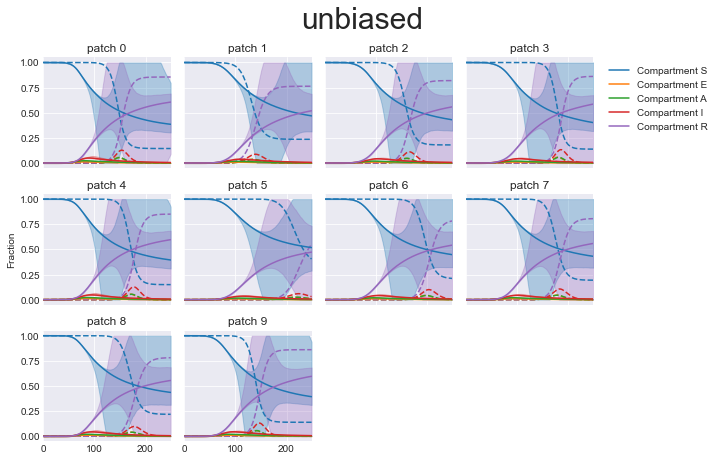

In [31]:
sparse_trajs_3 = gen_samples(sparse_mobility_matrix_3, timesteps =250, area = area, populations = population, sparse=True)
compare_to_ref(sparse_ref_traj_3, sparse_trajs_3, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0149 - weight-entropy: 6.9278
Epoch 2/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0140 - weight-entropy: 6.9218
Epoch 3/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0132 - weight-entropy: 6.9026
Epoch 4/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 6.8734
Epoch 5/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 6.8370
Epoch 6/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0114 - weight-entropy: 6.7960
Epoch 7/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0111 - weight-entropy: 6.7510
Epoch 8/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0107 - weight-entropy: 6.7133
Epoch 9/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0104 - weight-entropy: 6.6753
Epoch 10/500
8/8 [==============================] - 0s 3ms/step - loss: 0

8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1029
Epoch 80/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1168
Epoch 81/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.0774
Epoch 82/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1253
Epoch 83/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 4.1210
Epoch 84/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1260
Epoch 85/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0304
Epoch 86/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 3.9799
Epoch 87/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 3.9549
Epoch 88/500
8/8 [==============================] - 0s 2ms/step - loss: 0.001

8/8 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 3.8301
Epoch 157/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 3.7919
Epoch 158/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.6652
Epoch 159/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.6514
Epoch 160/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 3.8211
Epoch 161/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.5759
Epoch 162/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 3.7196
Epoch 163/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.6320
Epoch 164/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 3.6561
Epoch 165/500
8/8 [==============================] - 0s 2ms/step - lo

8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5775
Epoch 235/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.6615
Epoch 236/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.6895
Epoch 237/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.7137
Epoch 238/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.7894
Epoch 239/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.6366
Epoch 240/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6370
Epoch 241/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 3.8054
Epoch 242/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.6505
Epoch 243/500
8/8 [==============================] - 0s 2ms/step - lo

8/8 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.6858
Epoch 313/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.6178
Epoch 314/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 3.7026
Epoch 315/500
8/8 [==============================] - ETA: 0s - loss: 8.5088e-04 - weight-entropy: 3.60 - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.5851
Epoch 316/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.6485
Epoch 317/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.5534
Epoch 318/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 3.8124
Epoch 319/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0014 - weight-entropy: 3.6727
Epoch 320/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0014 - weight-entropy: 3.7083
Epoch 321/500
8/8

8/8 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.5532
Epoch 390/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4634
Epoch 391/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4516
Epoch 392/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.6541
Epoch 393/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.5424
Epoch 394/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.6961
Epoch 395/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.6120
Epoch 396/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.5197
Epoch 397/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 3.4925
Epoch 398/500
8/8 [==============================] - 0s 2ms/step - lo

8/8 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 3.5644
Epoch 468/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 3.6272
Epoch 469/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.4611
Epoch 470/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4327
Epoch 471/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.5920
Epoch 472/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4331
Epoch 473/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5209
Epoch 474/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 3.3574
Epoch 475/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 3.4349
Epoch 476/500
8/8 [==============================] - 0s 1ms/step - lo

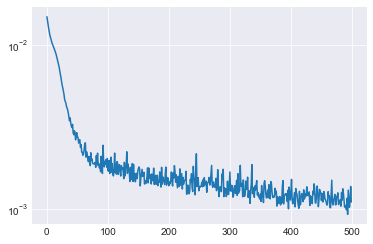

In [53]:
sparse_me_model_3 = maxent_fit(sparse_trajs_3, restraints_3)

In [54]:
me_w_3 = sparse_me_model_3.traj_weights
weights_dict_3 = {'unbiased':None, 'biased':me_w_3}
compare_patches(sparse_ref_traj_3, sparse_trajs_3, weights_dict_3,'biased', restrained_patches_3, plot_fxns_list_3,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

Plotting 10 patches in a 3 x 4 grid


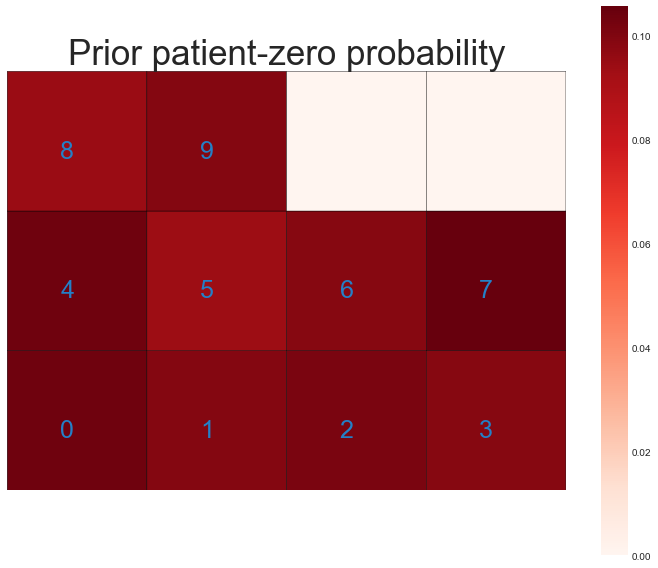

In [55]:
prior_exposed_patch_3 = maxentep.exposed_finder(sparse_trajs_3)
maxentep.p0_map(prior_exposed_patch_3, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_3, M, weights = me_w_3, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

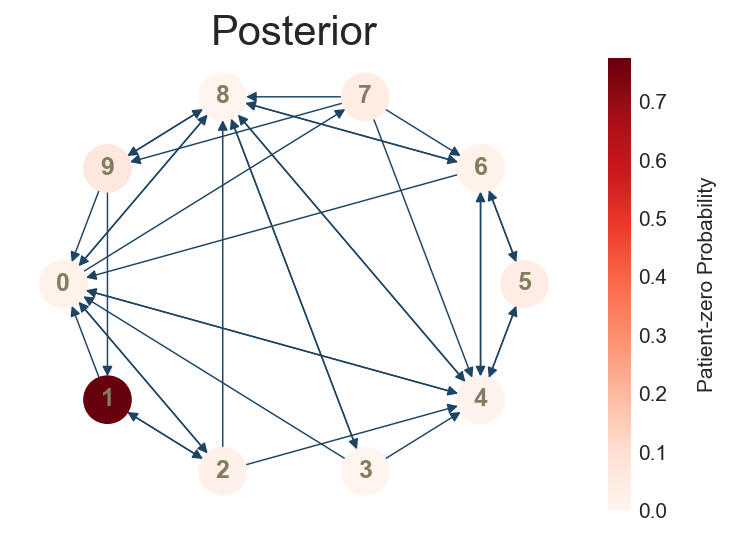

In [56]:
exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M)
weighted_exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M, weights=me_w_3)
maxentep.draw_graph(graph_3, weights=exposed_prob_3, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_3, weights=weighted_exposed_prob_3, title='Posterior', heatmap=True)

In [57]:
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_3, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.775823013601042, 'patch 1'), (0.05831875604837124, 'patch 9'), (0.04504276745334335, 'patch 7'), (0.04134471892403782, 'patch 5'), (0.023697148575177185, 'patch 2')]


# Case 4

In [72]:
graph_4, edge_list_4, node_list_4 = maxentep.gen_graph(10)
graph_4.remove_edges_from([(1, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i!=1])
graph_4.remove_edges_from([(i, 2) for i in range(4,9)])
graph_4.remove_edges_from([(i, 6) for i in range(0,4)])
graph_4.remove_edges_from([(i, 7) for i in range(1,10) if i!=7])
graph_4.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_4.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5] )
graph_4.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_4.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_4.remove_edges_from([(9,i) for i in range(2,8)])
graph_4.remove_edges_from([(i,9) for i in range(1,7)])
graph_4.remove_edges_from([(0, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 0) for i in range(3,8)])
graph_4.remove_edges_from([(i, 8) for i in range(2,6)])
graph_4.remove_edges_from([(8, i) for i in range(1,8) if i!=7 and i!=8])
graph_4.remove_edges_from([(i, 4) for i in range(6,9)])
maxentep.draw_graph(graph_4, dpi=100)
dof_4 = maxentep.graph_dof(graph_4.edges(), node_list_4)
dof_4

3.3


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


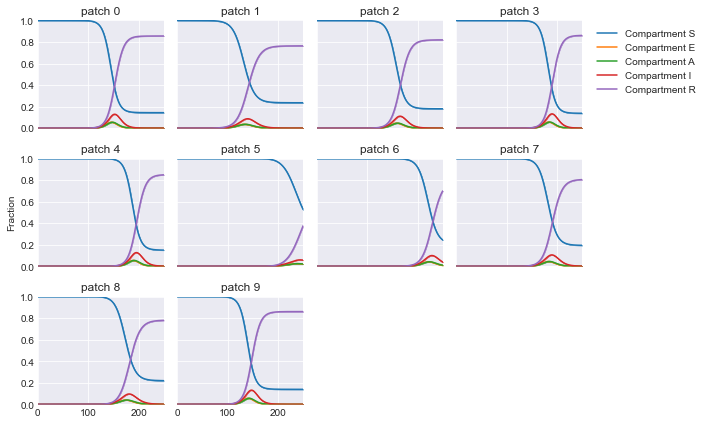

In [38]:
sparse_mobility_matrix_4 = sparse_graph_mobility(graph_4, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_4))
sparse_ref_traj_4 = gen_ref_traj(beta = 0.03, eta = 1/2, alpha=1/2, mu=1/5, M=10, timesteps=250, population=population, area=area,
                                 mobility_matrix=sparse_mobility_matrix_4)
maxentep.patch_quantile(sparse_ref_traj_4, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])


Restraints are set in this time range: [0, 180]
73 1.2166316e-05 0.02059087616797967
24 2.10714e-08 0.0
45 3.8359573e-07 0.0
171 0.098825455 0.12987031831288529
3 6.4674416e-12 0.0
94 0.00023259629 0.006612143804923939
52 1.3424786e-06 0.05080240091596692
108 0.0012012471 0.0
66 1.6818269e-05 0.0
108 0.0039054563 0.0
45 9.833207e-07 0.022482624060447667
143 0.12274196 0.14725816665349853
143 0.30952576 0.286378095634612
59 9.033357e-06 0.0
129 0.077034175 0.05699051098187169
87 0.00037693922 0.0
10 1.4652303e-15 0.010903400896386924
150 8.005891e-05 0.015879355180231935
80 5.106817e-09 0.00398679268126183
115 7.56298e-07 0.0
45 1.6275913e-11 0.0
24 1.2077157e-13 0.02486638768922387
101 1.3874296e-07 0.016253619585142855
108 3.7689475e-07 0.011745564482743043
171 0.047788728 0.024236148778883224
115 8.051841e-05 0.0
164 0.026089922 0.06118964466850725
38 1.152579e-09 0.0
164 0.047593206 0.06339743149412794
45 3.959913e-09 0.0022145412544068805
3 0.0 0.021558149521530307
94 6.404715e-06 

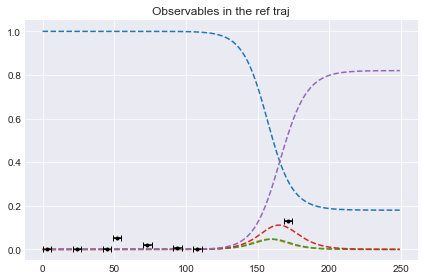

In [39]:
restraints_4, plot_fxns_list_4, restrained_patches_4 = gen_restraints(sparse_ref_traj_4)

In [40]:
sparse_trajs_4 = gen_samples(sparse_mobility_matrix_4, timesteps =250, area = area, populations = population, sparse=True)
compare_to_ref(sparse_ref_traj_4, sparse_trajs_4, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:28<00:00,  1.76s/it]


Plotting 10 patches in a 3 x 4 grid


Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0082 - weight-entropy: 6.9226
Epoch 2/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0043 - weight-entropy: 6.8783
Epoch 3/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 6.8269
Epoch 4/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 6.7867
Epoch 5/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 6.7596
Epoch 6/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 6.7415
Epoch 7/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 6.7295
Epoch 8/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 6.7215
Epoch 9/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 6.7155
Epoch 10/500
8/8 [==============================] - 0s 2ms/step - loss: 0

8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 6.3971
Epoch 80/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 6.3879
Epoch 81/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 6.3781
Epoch 82/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 6.3699
Epoch 83/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 6.3626
Epoch 84/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.3517
Epoch 85/500
8/8 [==============================] - ETA: 0s - loss: 9.5993e-04 - weight-entropy: 6.30 - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.3431
Epoch 86/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.3328
Epoch 87/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 6.3231
Epoch 88/500
8/8 [=======

8/8 [==============================] - 0s 2ms/step - loss: 5.7940e-04 - weight-entropy: 5.5938
Epoch 155/500
8/8 [==============================] - 0s 2ms/step - loss: 5.6275e-04 - weight-entropy: 5.5838
Epoch 156/500
8/8 [==============================] - 0s 2ms/step - loss: 5.5459e-04 - weight-entropy: 5.5625
Epoch 157/500
8/8 [==============================] - 0s 2ms/step - loss: 5.5277e-04 - weight-entropy: 5.5516
Epoch 158/500
8/8 [==============================] - 0s 2ms/step - loss: 5.6486e-04 - weight-entropy: 5.5501
Epoch 159/500
8/8 [==============================] - 0s 2ms/step - loss: 5.5279e-04 - weight-entropy: 5.5246
Epoch 160/500
8/8 [==============================] - 0s 2ms/step - loss: 5.5353e-04 - weight-entropy: 5.5311
Epoch 161/500
8/8 [==============================] - 0s 2ms/step - loss: 5.4531e-04 - weight-entropy: 5.5176
Epoch 162/500
8/8 [==============================] - 0s 2ms/step - loss: 5.3768e-04 - weight-entropy: 5.5077
Epoch 163/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 3.9466e-04 - weight-entropy: 4.9011
Epoch 230/500
8/8 [==============================] - 0s 2ms/step - loss: 4.0521e-04 - weight-entropy: 4.8080
Epoch 231/500
8/8 [==============================] - 0s 2ms/step - loss: 4.0236e-04 - weight-entropy: 4.8866
Epoch 232/500
8/8 [==============================] - 0s 2ms/step - loss: 4.1356e-04 - weight-entropy: 4.8894
Epoch 233/500
8/8 [==============================] - 0s 2ms/step - loss: 3.8201e-04 - weight-entropy: 4.7787
Epoch 234/500
8/8 [==============================] - 0s 2ms/step - loss: 4.0848e-04 - weight-entropy: 4.8559
Epoch 235/500
8/8 [==============================] - 0s 2ms/step - loss: 3.4935e-04 - weight-entropy: 4.6948
Epoch 236/500
8/8 [==============================] - 0s 2ms/step - loss: 3.9734e-04 - weight-entropy: 4.8140
Epoch 237/500
8/8 [==============================] - 0s 2ms/step - loss: 3.4748e-04 - weight-entropy: 4.7015
Epoch 238/500
8/8 [==============

8/8 [==============================] - 0s 3ms/step - loss: 3.3884e-04 - weight-entropy: 4.4348
Epoch 305/500
8/8 [==============================] - 0s 2ms/step - loss: 3.6078e-04 - weight-entropy: 4.4213
Epoch 306/500
8/8 [==============================] - 0s 2ms/step - loss: 3.2997e-04 - weight-entropy: 4.2961
Epoch 307/500
8/8 [==============================] - 0s 2ms/step - loss: 3.6281e-04 - weight-entropy: 4.4945
Epoch 308/500
8/8 [==============================] - 0s 2ms/step - loss: 3.5748e-04 - weight-entropy: 4.4355
Epoch 309/500
8/8 [==============================] - 0s 2ms/step - loss: 3.2623e-04 - weight-entropy: 4.3161
Epoch 310/500
8/8 [==============================] - 0s 2ms/step - loss: 3.3275e-04 - weight-entropy: 4.3753
Epoch 311/500
8/8 [==============================] - 0s 1ms/step - loss: 3.0453e-04 - weight-entropy: 4.2133
Epoch 312/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1809e-04 - weight-entropy: 4.2515
Epoch 313/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 3.0083e-04 - weight-entropy: 4.0310
Epoch 380/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1051e-04 - weight-entropy: 4.1255
Epoch 381/500
8/8 [==============================] - 0s 2ms/step - loss: 3.5098e-04 - weight-entropy: 4.2205
Epoch 382/500
8/8 [==============================] - 0s 2ms/step - loss: 3.7040e-04 - weight-entropy: 4.2255
Epoch 383/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1496e-04 - weight-entropy: 4.0945
Epoch 384/500
8/8 [==============================] - 0s 2ms/step - loss: 3.0925e-04 - weight-entropy: 4.1169
Epoch 385/500
8/8 [==============================] - 0s 2ms/step - loss: 3.0737e-04 - weight-entropy: 4.0381
Epoch 386/500
8/8 [==============================] - 0s 2ms/step - loss: 3.4336e-04 - weight-entropy: 4.2517
Epoch 387/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1947e-04 - weight-entropy: 4.1267
Epoch 388/500
8/8 [==============

8/8 [==============================] - 0s 2ms/step - loss: 3.0815e-04 - weight-entropy: 4.0312
Epoch 454/500
8/8 [==============================] - 0s 2ms/step - loss: 3.3371e-04 - weight-entropy: 4.0504
Epoch 455/500
8/8 [==============================] - 0s 2ms/step - loss: 3.3220e-04 - weight-entropy: 4.0310
Epoch 456/500
8/8 [==============================] - 0s 2ms/step - loss: 3.3528e-04 - weight-entropy: 4.1867
Epoch 457/500
8/8 [==============================] - 0s 2ms/step - loss: 3.2875e-04 - weight-entropy: 4.0493
Epoch 458/500
8/8 [==============================] - 0s 2ms/step - loss: 3.3304e-04 - weight-entropy: 4.0609
Epoch 459/500
8/8 [==============================] - 0s 2ms/step - loss: 3.1718e-04 - weight-entropy: 3.9433
Epoch 460/500
8/8 [==============================] - 0s 2ms/step - loss: 3.4118e-04 - weight-entropy: 4.1385
Epoch 461/500
8/8 [==============================] - 0s 2ms/step - loss: 3.2920e-04 - weight-entropy: 4.1576
Epoch 462/500
8/8 [==============

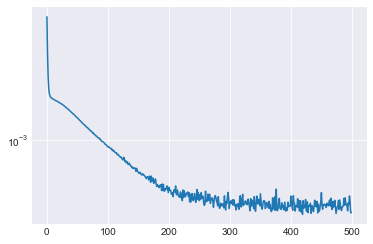

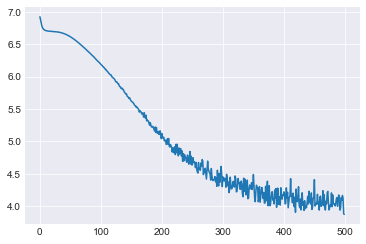

In [41]:
sparse_me_model_4 = maxent_fit(sparse_trajs_4, restraints_4)

Plotting 10 patches in a 3 x 4 grid


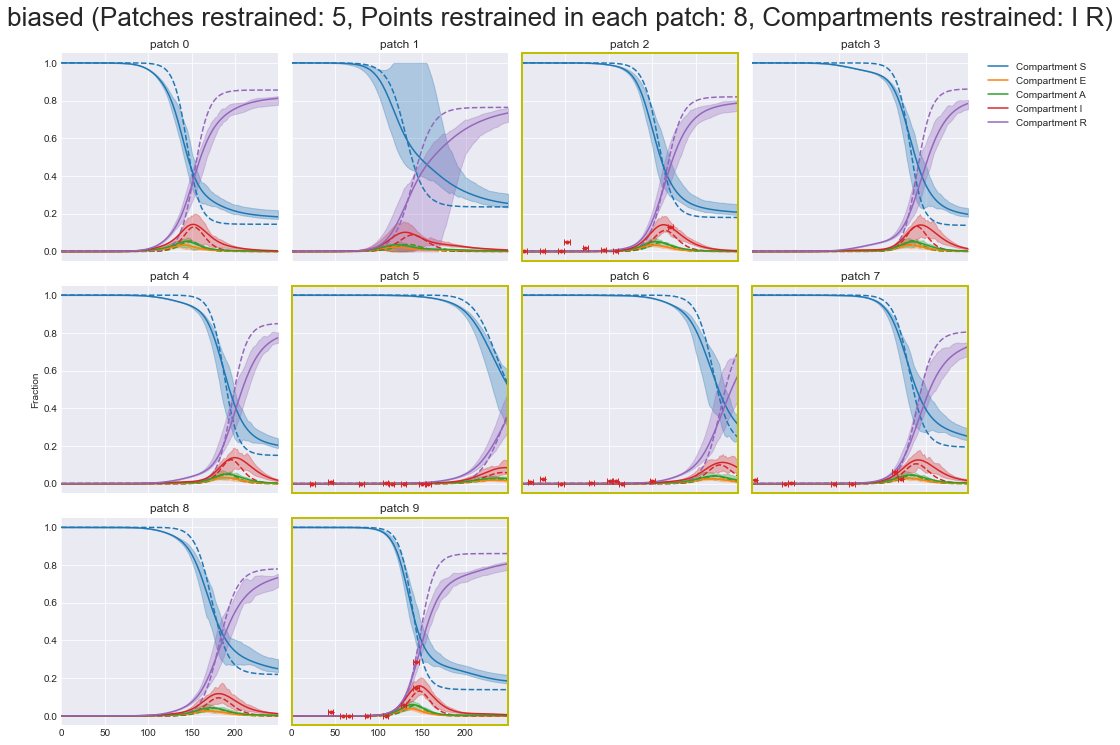

In [42]:
me_w_4 = sparse_me_model_4.traj_weights
weights_dict_4 = {'unbiased':None, 'biased':me_w_4}
compare_patches(sparse_ref_traj_4, sparse_trajs_4, weights_dict_4,'biased', restrained_patches_4, plot_fxns_list_4,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

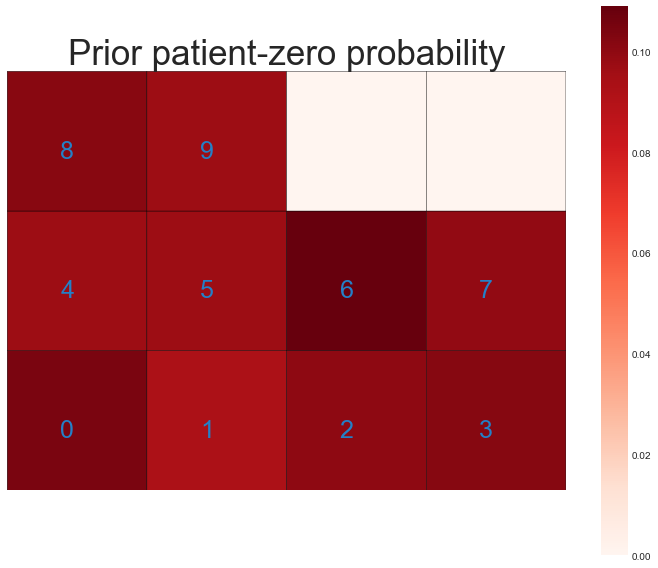

In [43]:
prior_exposed_patch_4 = maxentep.exposed_finder(sparse_trajs_4)
maxentep.p0_map(prior_exposed_patch_4, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_4, M, weights = me_w_4, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))


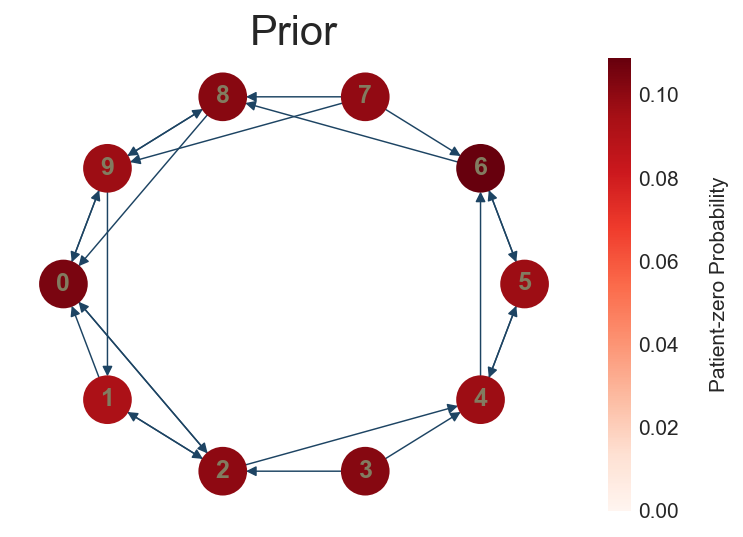

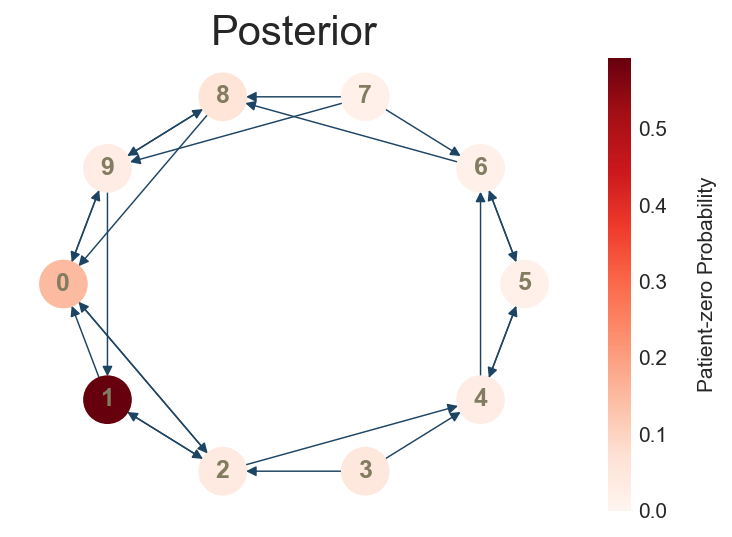

In [44]:
exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M)
weighted_exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M, weights=me_w_4)
maxentep.draw_graph(graph_4, weights=exposed_prob_4, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_4, weights=weighted_exposed_prob_4, title='Posterior', heatmap=True)

In [45]:
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_4, patches), reverse=True)[:5])

Top 5 posterior probabilities for P0: 
 [(0.5934354402320642, 'patch 1'), (0.15044354438725988, 'patch 0'), (0.06008516852501091, 'patch 8'), (0.050492619520976584, 'patch 3'), (0.04060906988724897, 'patch 2')]


In [82]:
p0_probs = [max(weighted_exposed_prob_1),max(weighted_exposed_prob_2),max(weighted_exposed_prob_3),max(weighted_exposed_prob_4)]
dofs = [dof_1, dof_2, dof_3, dof_4]
fig, ax = plt.subplots(dpi=100)
plt.scatter(dofs,p0_probs)
ax.set_xlabel('Graph dof')
ax.set_ylabel('Certainty in the Origin of Patinet-zero ')

Text(0, 0.5, 'Certainty in the Origin of Patinet-zero ')